# Roadmap Epigenomics ChIP 12 kb

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import h5py
import json
import numpy as np
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# The base directory is one level up
base = '..'
size = '12kb'
name = 'roadmap-chip-{}-init'.format(size)
settings_filepath = 'settings-roadmap-epigenomics-chip-histone-mod-{}.json'.format(size)
search_name = 'cnn-final'
search_filepath = '{}.json'.format(search_name)
datasets_filepath = "datasets-chip-histone-mod-hg19.json"

with open(os.path.join(base, settings_filepath), "r") as f:
    settings = json.load(f)

with open(os.path.join(base, search_filepath), "r") as f:
    search = json.load(f)
    
dataset = 'roadmap-chip_w-{}_f-{}_r-{}'.format(
    settings['window_size'],
    settings['step_frequency'],
    settings['resolution'],
)

with h5py.File(os.path.join(base, 'data', '{}.h5'.format(dataset)), 'r') as f:
    print()
    print('Dataset: {}'.format(dataset))
    print('Training samples: {}'.format(f['data_train'].shape[0]),)
    print('Dev samples: {}'.format(f['data_dev'].shape[0]))
    print('Test samples: {}'.format(f['data_test'].shape[0]))
    print('---')
    print('Total samples: {}'.format(f['data_train'].shape[0] + f['data_dev'].shape[0] + f['data_test'].shape[0]))


Dataset: roadmap-chip_w-12000_f-3_r-100
Training samples: 24090195
Dev samples: 2125605
Test samples: 2125634
---
Total samples: 28341434


## Check if data is available

In [23]:
"""Check if all narrowPeak and broadPeak files have been converted to bigBeds"""

import h5py
import pathlib

try:
    with open(os.path.join(base, datasets_filepath), "r") as f:
        all_datasets = json.load(f)
except FileNotFoundError:
    all_datasets = []
    print("Damn! Where is the file with the Roadmap Epigenomics experiments?")

not_found = []

for e_id in all_datasets:
    for target in settings["targets"]:
        infile = '../data/{}-{}.narrowPeak.gz'.format(e_id, target)
        outfile = '../data/{}-{}.peaks.narrow.bigBed'.format(e_id, target)
        
        if not pathlib.Path(outfile).is_file():
            not_found.append((infile, outfile))
            
        infile = '../data/{}-{}.broadPeak.gz'.format(e_id, target)
        outfile = '../data/{}-{}.peaks.broad.bigBed'.format(e_id, target)
        
        if not pathlib.Path(outfile).is_file():
            not_found.append((infile, outfile))

print("{} are not found".format(len(not_found)))

0 are not found


## Prepare data

In [27]:
from prepare import prepare_jobs

prepare_jobs(
    'ChIP',
    datasets_filepath,
    settings_filepath,
    roadmap=True,
    base=base,
    clear=False,
    verbose=False,
)

Created a slurm file for preparing 49 datasets


Run `sbatch prepare.slurm`

## Check if all datasets have been prepared

In [31]:
import h5py

try:
    with open(os.path.join(base, datasets_filepath), "r") as f:
        all_datasets = json.load(f)
except FileNotFoundError:
    all_datasets = []
    print("Damn! Where is the file with the ENCODE experiments?")

not_found = []
outdated = []
total_size = 0

for dataset in all_datasets:
    filepath = os.path.join(
        base,
        'data',
        '{}_w-{}_f-{}_r-{}.h5'.format(
            dataset,
            settings["window_size"],
            settings["step_frequency"],
            settings["resolution"]
        )
    )
    total_size += os.path.getsize(filepath)
    try:
        with h5py.File(filepath, "r") as f:
            try:
                x = f['data_train']
                x = f['data_dev']
                x = f['data_test']
                x = f['peaks_train']
                x = f['peaks_dev']
                x = f['peaks_test']
                x = f['shuffling']
                x = f['settings']
            except KeyError:
                outdated.append(dataset)
    except OSError:
        not_found.append(dataset)

print("{} are not found".format(len(not_found)))
print("{} are not outdated".format(len(outdated)))

0 are not found
0 are not outdated


## Merge datasets

See `merge-chip-12kb.slurm` and `merge-chip-12kb-cnn-search.slurm`

## Create training jobs

In [2]:
from jobs import jobs

jobs(
    search_filepath,
    settings_filepath,
    dataset=dataset,
    name=name,
    cluster='cox',
    epochs=5,
    batch_size=256,
    repeat=3,
    base=base,
    clear=True,
    verbose=False
)


Created slurm file for training 1 neural networks


#### Check training

In [4]:
from ae.utils import check_status

okay, not_found, outdated = check_status(
    search_name, 'training', dataset, base=base
)

if okay:
    print('Trainings completed')
else:
    print('Trainings did not finish. Missing {}'.format(len(not_found)))

Trainings completed


## Create evaluation jobs

In [5]:
from evaluate import create_jobs

create_jobs(
    search_name,
    name=name,
    dataset=dataset,
    cluster='seasdgx1',
    base=base,
    incl_dtw=False,
)

Created slurm file for evaluating 3 neural networks


In a terminal run: `sbatch evaluate-cnn-final-test.slurm`

In [10]:
from ae.utils import check_status

okay, not_found, outdated = check_status(
    search_name, 'evaluation', dataset, base=base
)

if okay:
    print('Evaluation completed')
else:
    print('Evaluation did not finish. Missing {}'.format(len(not_found)))

Evaluation completed


## Compare

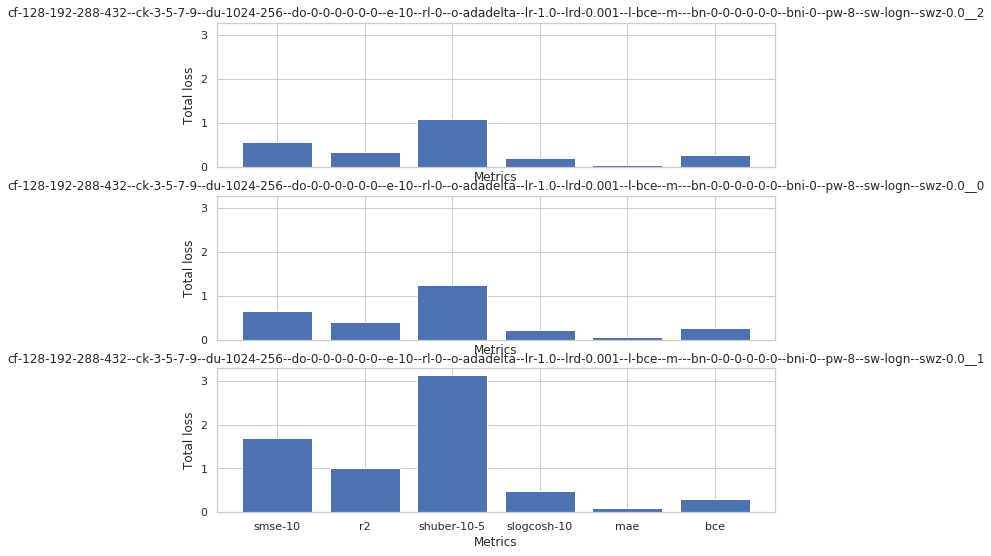

In [11]:
from compare import compare
    
performance = compare(
    'definitions-{}.json'.format(search_name),
    dataset_name=dataset,
    base=base,
    clear=False,
    verbose=False,
    silent=False,
    remove_common_prefix_from_df=True,
)

In [12]:
import qgrid

qgw = qgrid.show_grid(performance)
qgw

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Repetition #0


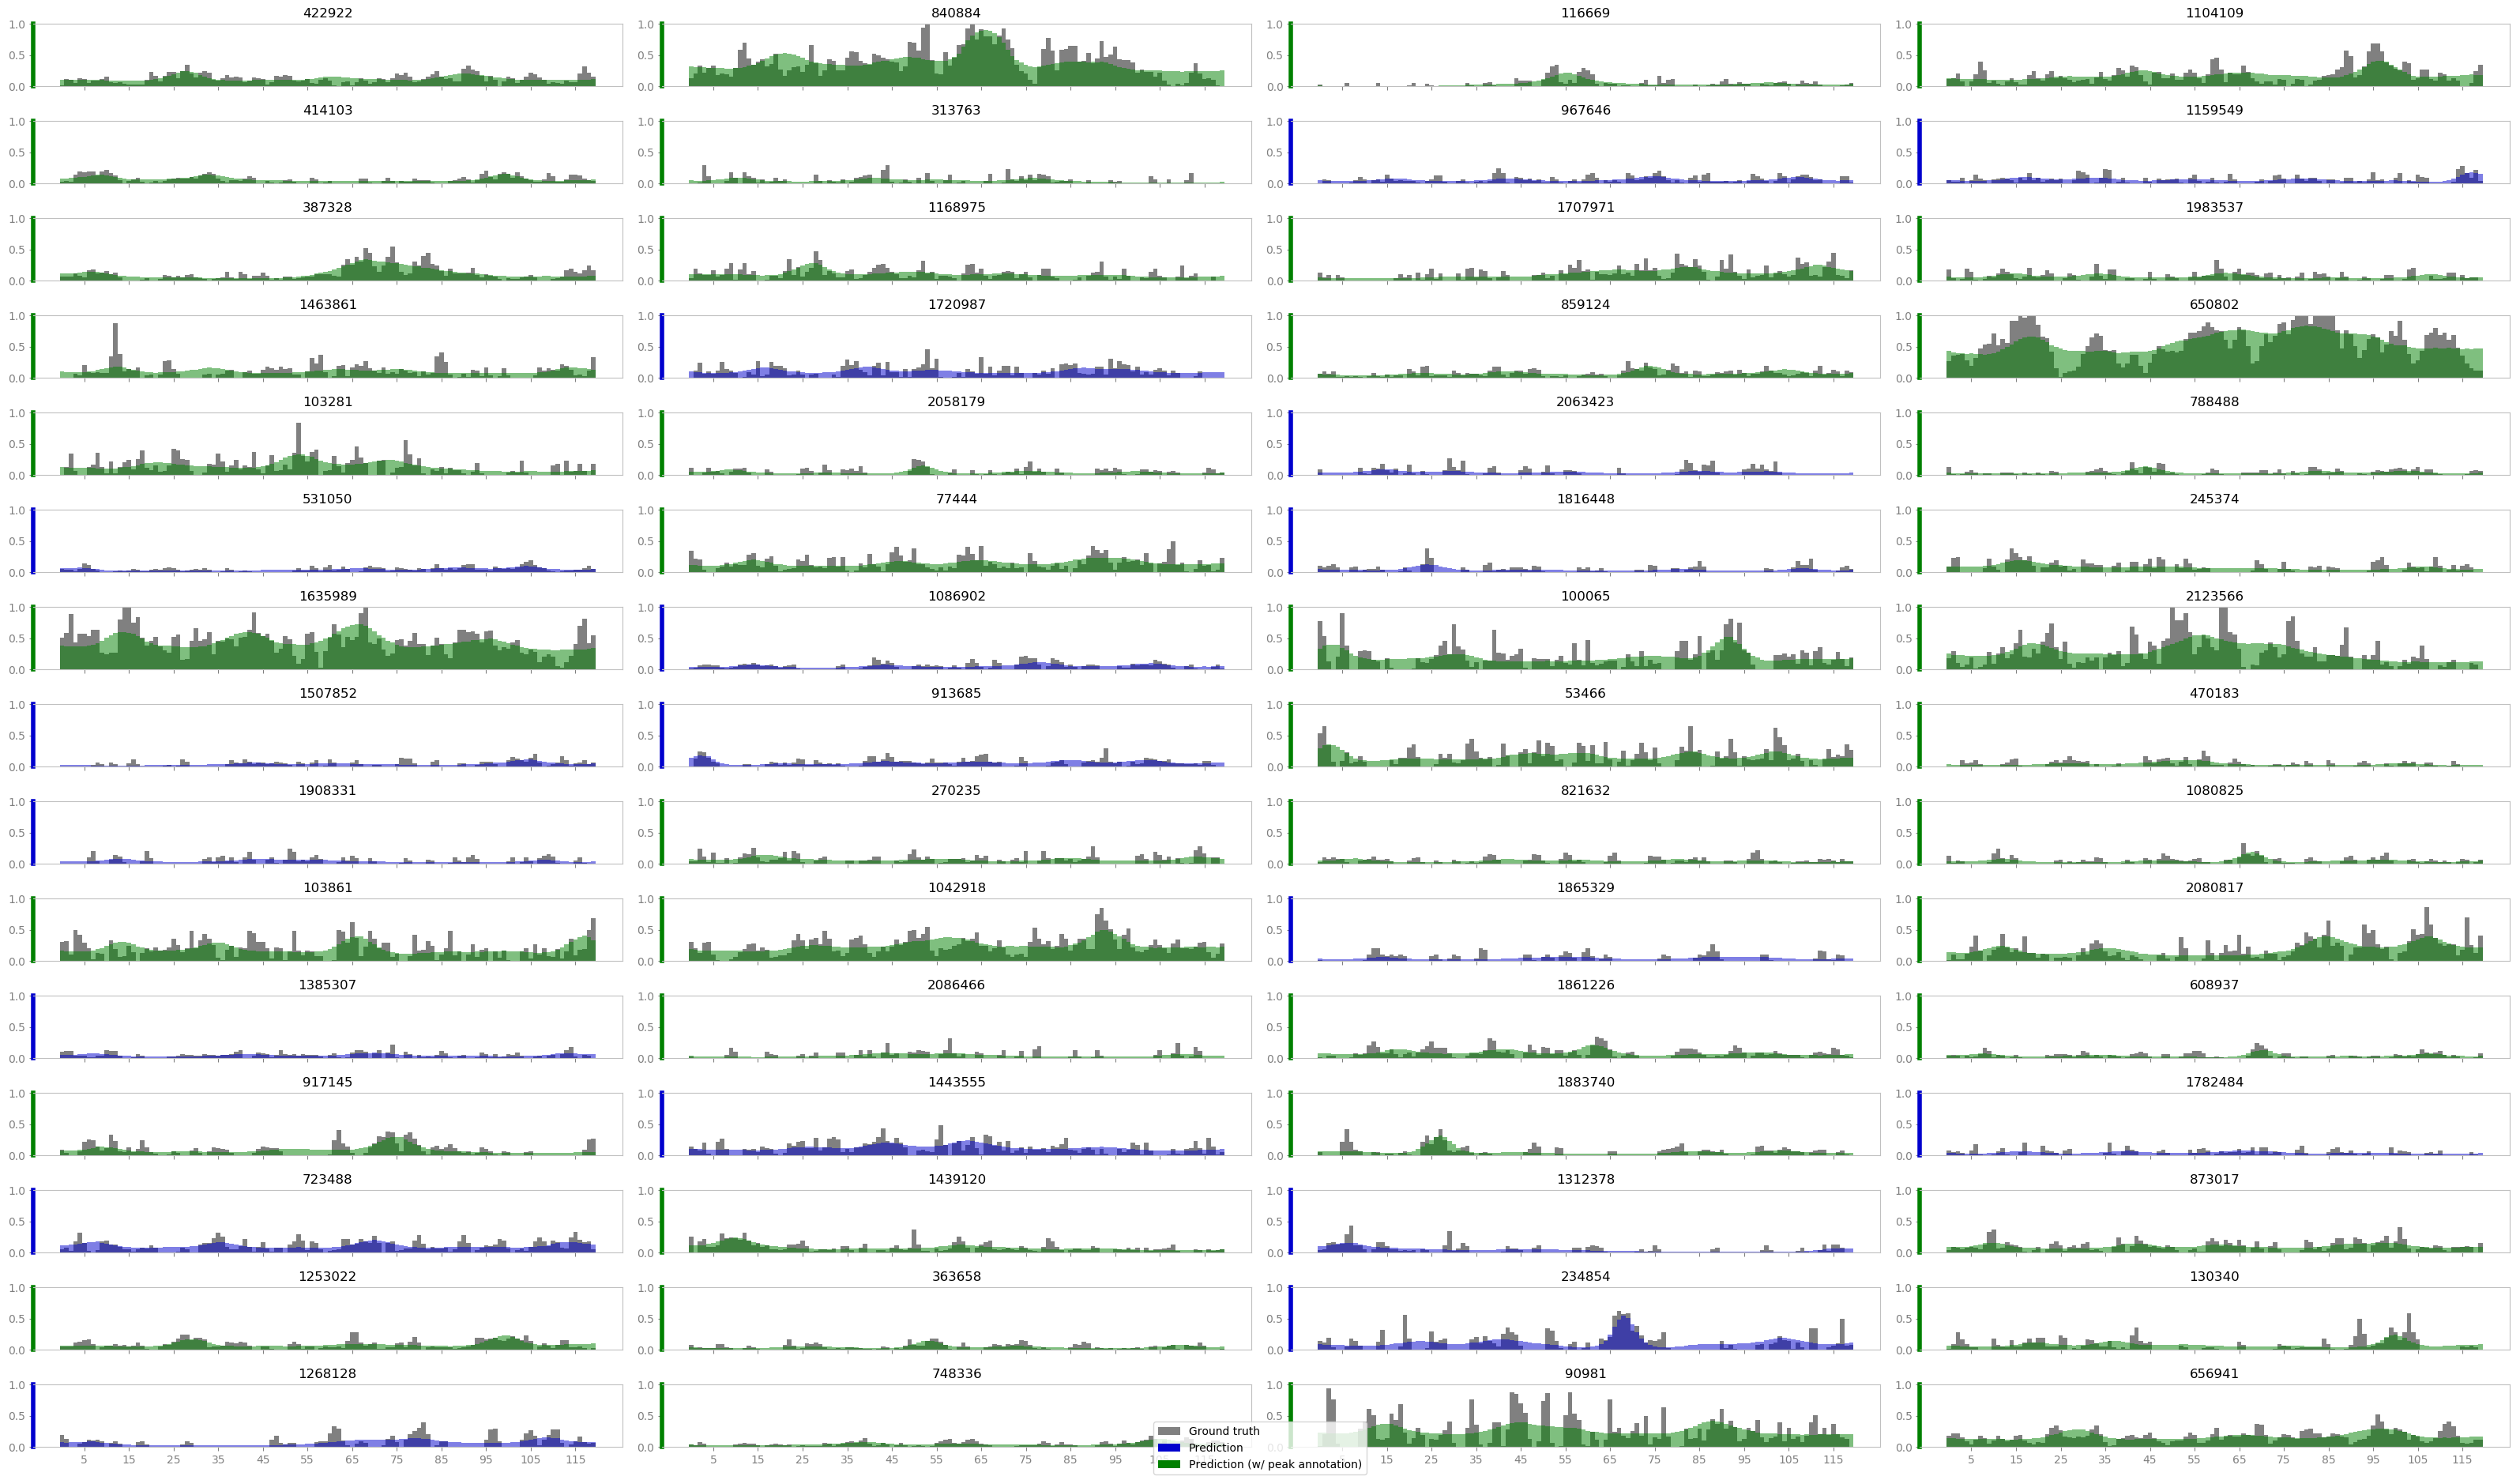

Repetition #2


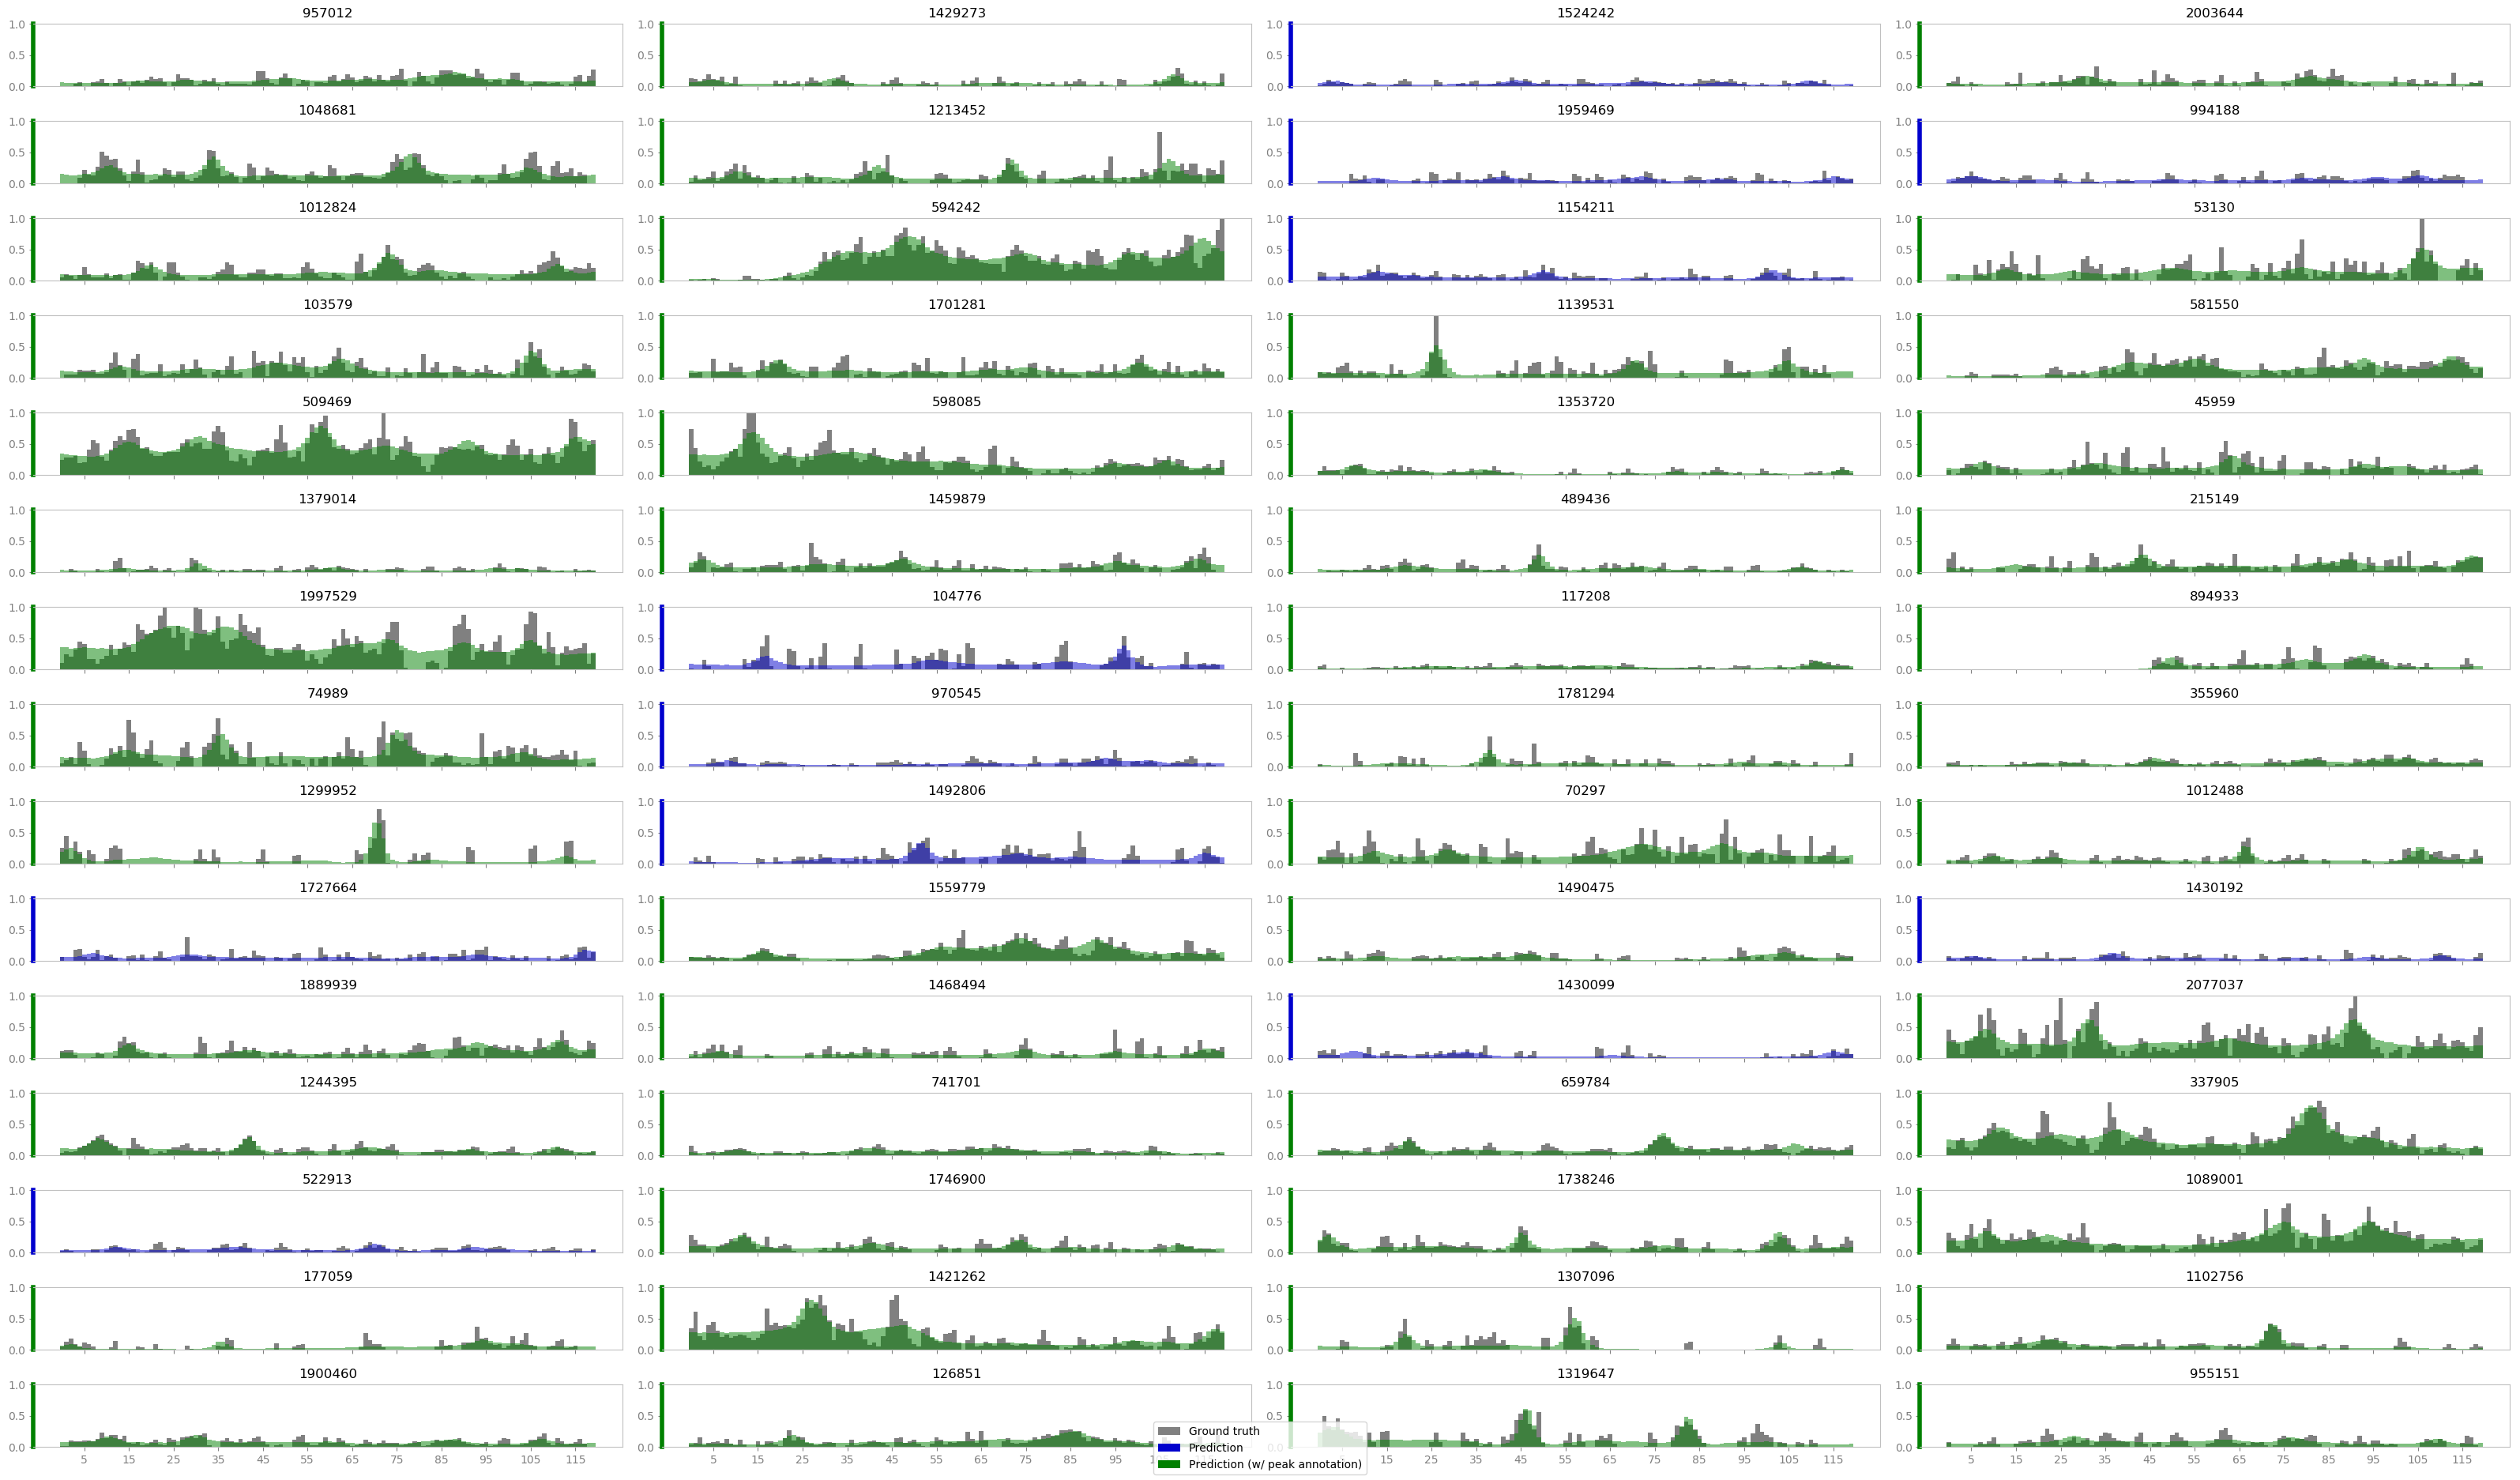

In [14]:
from IPython.core.display import Image, display
from itertools import takewhile


with open(os.path.join(base, 'definitions-{}.json'.format(search_name)), 'r') as f:
    definitions = json.load(f)

lcp = ''.join(c[0] for c in takewhile(lambda x: all(x[0] == y for y in x), zip(*definitions)))

for model in qgw.get_selected_df().iterrows():
    model_name, repetition = (lcp + model[0]).split('__')
    print('Repetition #{}'.format(repetition))
    display(Image(os.path.join(base, 'models', '{}---predictions-{}__{}.png'.format(model_name, dataset, repetition))))

In [10]:
from ae.cnn import create_model

bins_per_window = settings["window_size"] // settings["resolution"]

with open(os.path.join(base, 'definitions-{}.json'.format(search_name)), 'r') as f:
    definition = json.load(f)[0]

with open(os.path.join(base, 'models/{}.json'.format(definition)), 'r') as f:
    definition = json.load(f)

definition.pop("peak_weight", None)
definition.pop("signal_weighting", None)
definition.pop("signal_weighting_zero_point_percentage", None)

_, _, autoencoder = create_model(bins_per_window, **definition)

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 120, 1)            0         
_________________________________________________________________
conv0 (Conv1D)               (None, 60, 128)           512       
_________________________________________________________________
conv1 (Conv1D)               (None, 30, 192)           123072    
_________________________________________________________________
conv2 (Conv1D)               (None, 15, 288)           387360    
_________________________________________________________________
conv3 (Conv1D)               (None, 8, 432)            1120176   
_________________________________________________________________
flatten (Flatten)            (None, 3456)              0         
_________________________________________________________________
fc4 (Dense)                  (None, 1024)              3539968   
__________

In [ ]:
ae.get_summary()

---

# Retrain

Run `sbatch train-roadmap-chip-12kb-retrain.slurm`

In [6]:
from ae.utils import check_status

model_name='cf-128-192-288-432--ck-3-5-7-9--du-1024-256--do-0-0-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-bce--m---bn-0-0-0-0-0-0--bni-0--pw-8--sw-logn--swz-0.0'

okay, not_found, outdated = check_status(
    search_name,
    'training',
    dataset=dataset,
    base=base,
    re_trained=True,
    model_name=model_name
)

if okay:
    print('Training completed')
else:
    print('Training did not finish. Missing {}'.format(len(not_found)))

Training completed


## Evaluation

Run `sbatch evaluate-roadmap-chip-12kb-retrain.slurm`

In [4]:
from ae.utils import check_status

model_name='cf-128-192-288-432--ck-3-5-7-9--du-1024-256--do-0-0-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-bce--m---bn-0-0-0-0-0-0--bni-0--pw-8--sw-logn--swz-0.0'

okay, not_found, outdated = check_status(
    search_name,
    'evaluation',
    dataset=dataset,
    base=base,
    re_trained=True,
    model_name=model_name
)

if okay:
    print('Evaluation completed')
else:
    print('Evaluation did not finish. Missing {}'.format(len(not_found)))

Evaluation completed


[0.50210491 0.30875563 0.25957371]
[[4543.93848192 4538.06005955 4521.87142277 4612.32571936]]


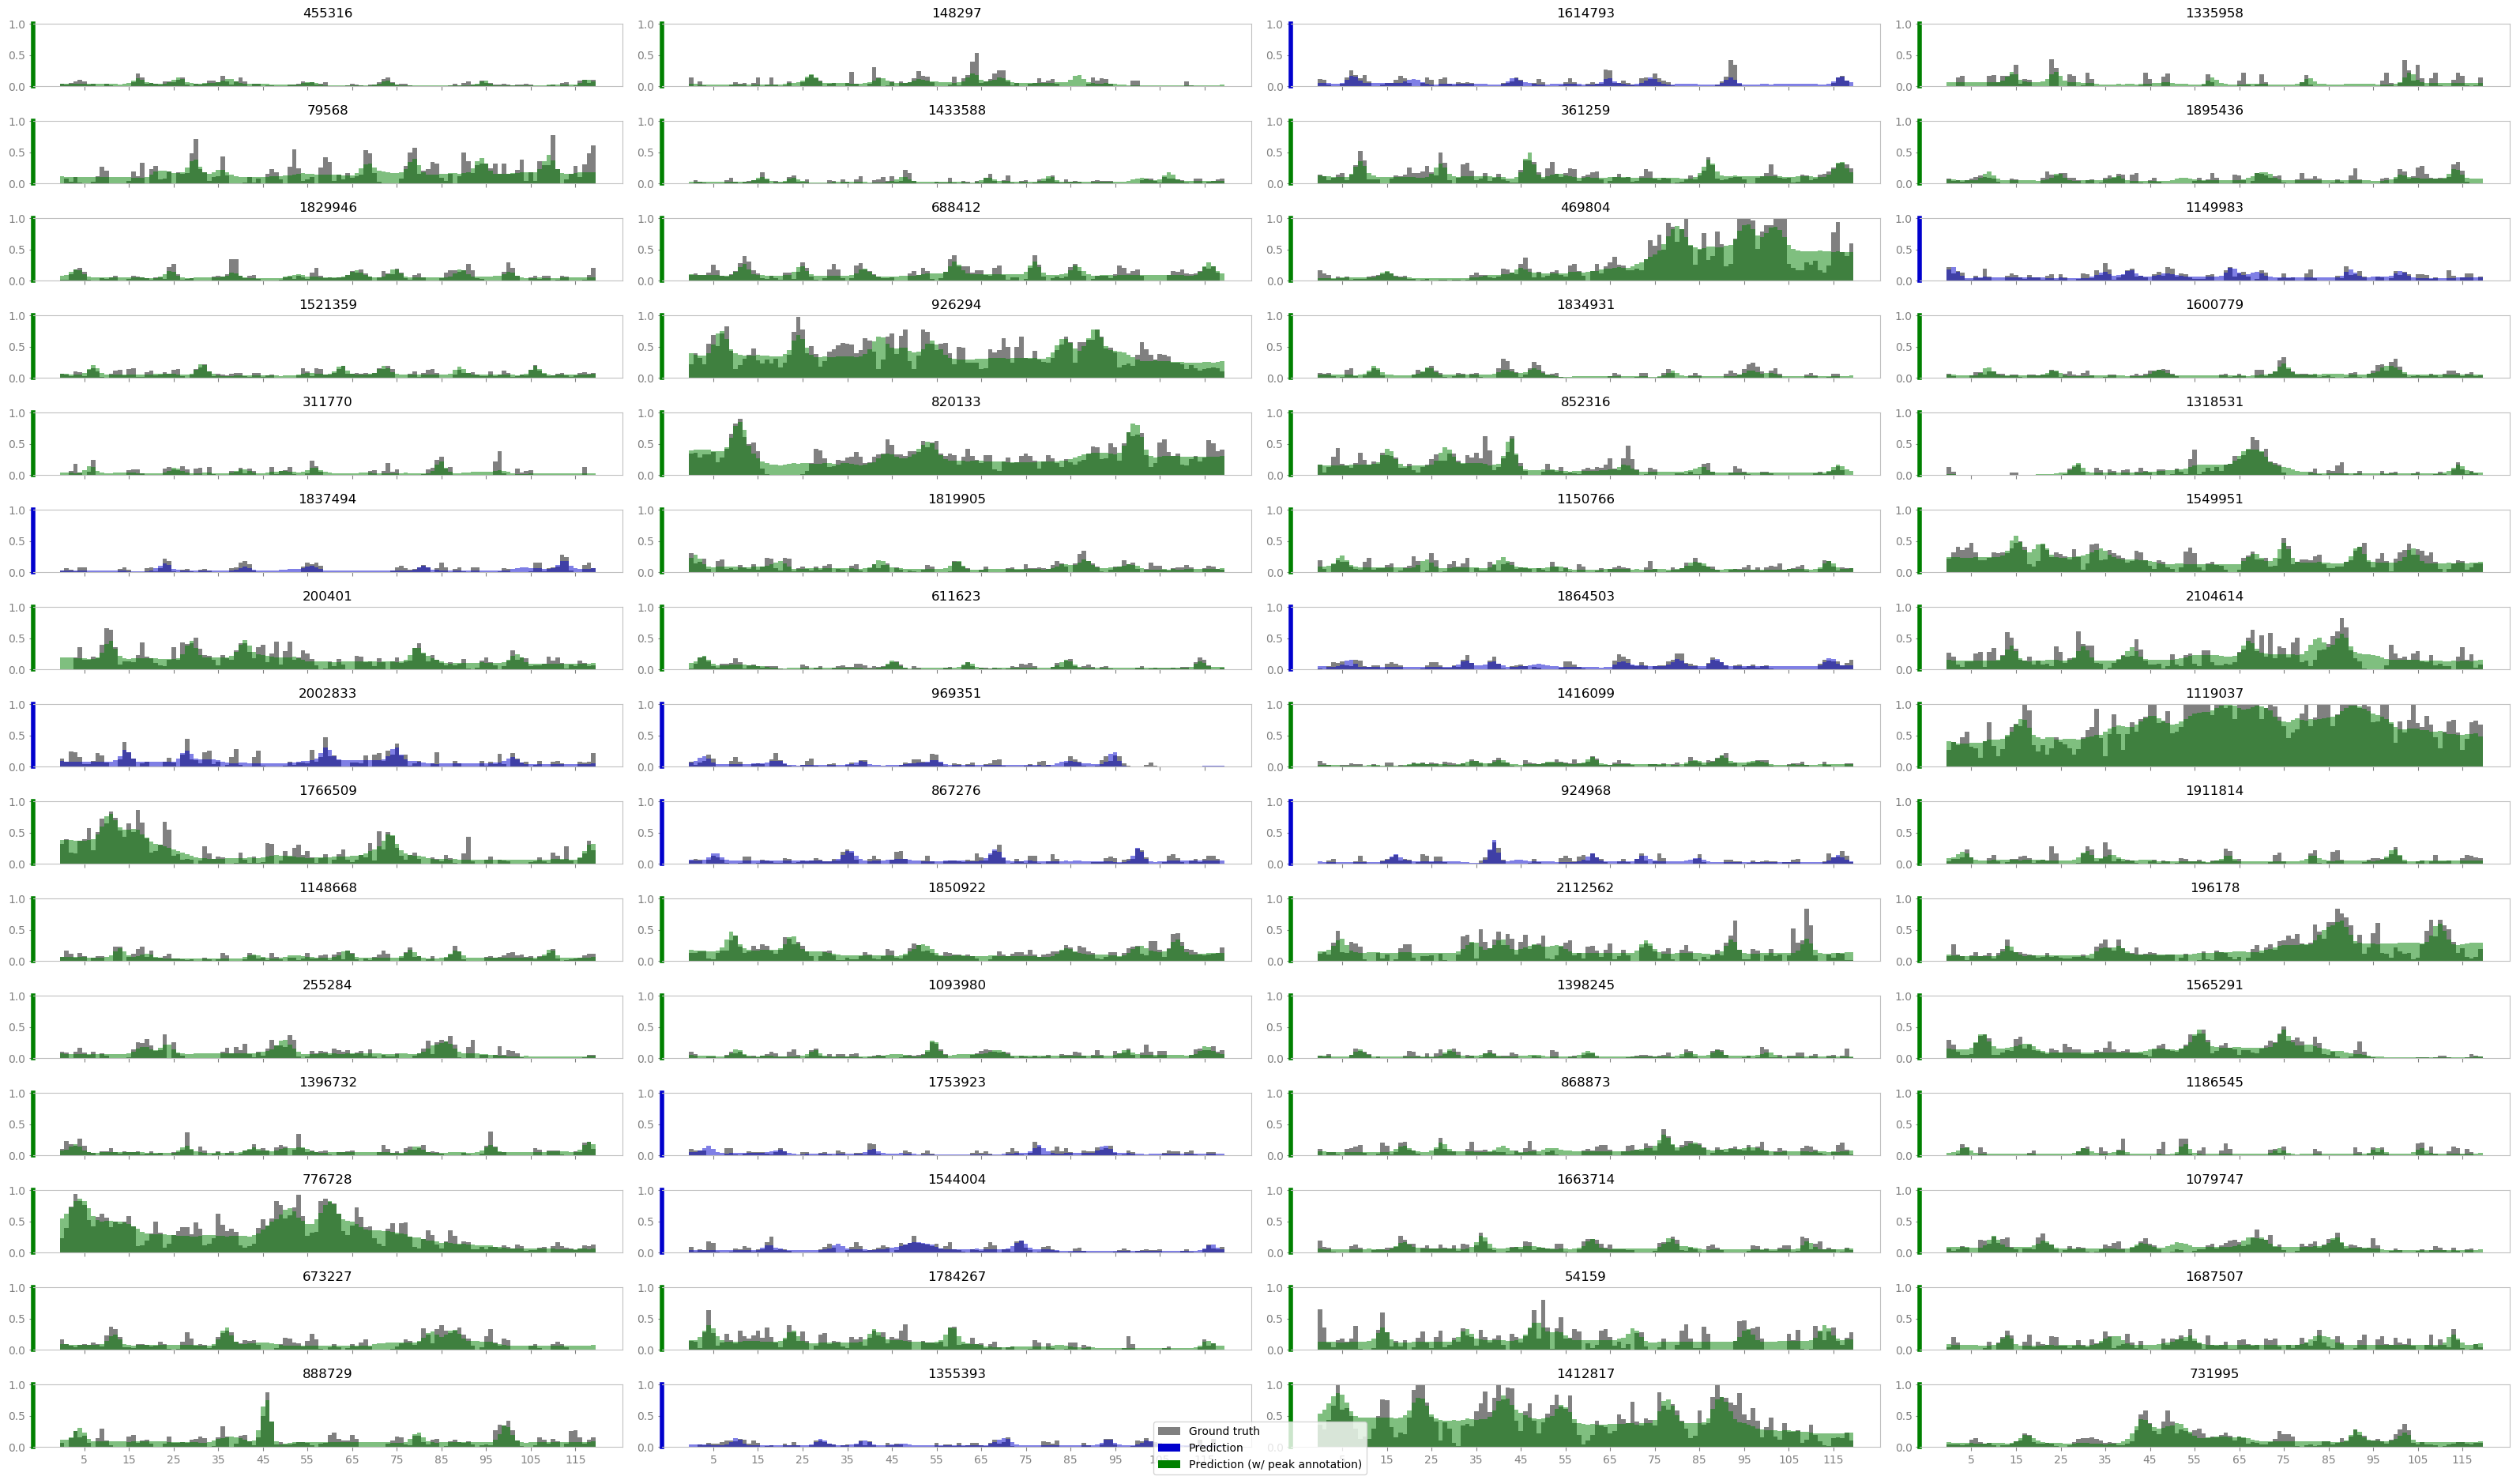

In [5]:
import h5py
from IPython.core.display import Image, display

with h5py.File(os.path.join(base, 'models', '{}---evaluation-{}-re-trained.h5'.format(model_name, dataset)), 'r') as f:
    print(np.mean(f['total_loss'], axis=0))
    print(f['total_times'][:])

display(Image(os.path.join(base, 'models', '{}---predictions-{}-re-trained.png'.format(model_name, dataset))))

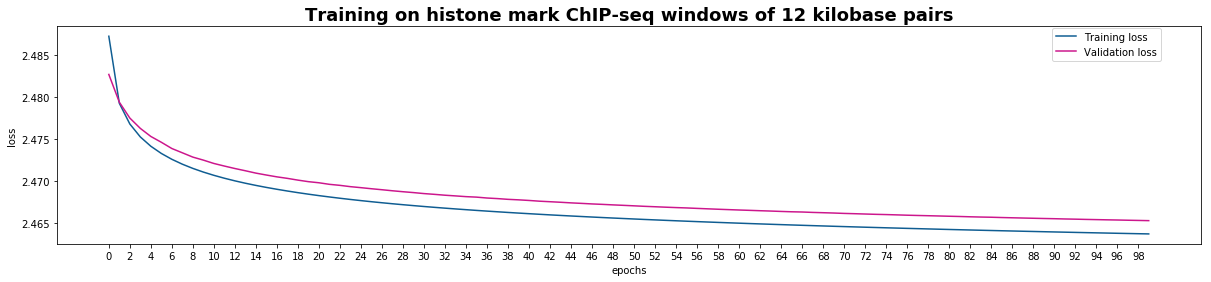

In [12]:
from train import plot_loss_to_file

with h5py.File(os.path.join(base, "models", "{}---training-{}-re-trained.h5".format(model_name, dataset)), "r") as f:
    plot_loss_to_file(
        f['loss'][:],
        f['val_loss'][:],
        model_name,
        dataset_name=dataset,
        title="Training on histone mark ChIP-seq windows of 12 kilobase pairs",
        base=base,
    )

## Plot individual windows

/n/pfister_lab/haehn/ENVS/peax/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


(array([ 361259,  196178, 1412817]),
 array([17.52201258, 24.79577069, 53.41422889]),
 array([0.51823348, 0.84323442, 1.        ]))

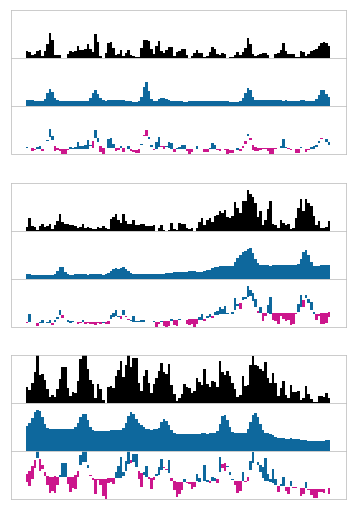

In [2]:
from ae.utils import plot_windows

plot_windows(
    dataset,
    model_name='cf-128-192-288-432--ck-3-5-7-9--du-1024-256--do-0-0-0-0-0-0--e-10--rl-0--o-adadelta--lr-1.0--lrd-0.001--l-bce--m---bn-0-0-0-0-0-0--bni-0--pw-8--sw-logn--swz-0.0',
    ds_type="test",
    window_ids=[361259, 196178, 1412817],
    base=base,
    trained_on_single_dataset=True,
    re_trained=True,
    no_legend=True,
    no_peak_coloring=True,
    diff=True,
    plot_reconst_separately=True,
    no_title=True
)